<a href="https://colab.research.google.com/github/Kaia-nyoung/2025-ML-class/blob/main/4%EC%A3%BC%EC%B0%A8/breast_cancer_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import random

In [2]:
SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)

In [3]:
df = pd.read_csv("/content/drive/MyDrive/ML-MK/breast_cancer.csv")

In [4]:
# 2) Drop index-like column(s) and split X/y
drop_cols = [c for c in ["Unnamed: 0"] if c in df.columns]
df = df.drop(columns=drop_cols)

assert "label" in df.columns, "타깃(label) 컬럼이 필요합니다."
X = df.drop(columns=["label"])
y = df["label"].astype(int).values  # 0/1

print("Data shape:", X.shape, " | Positive rate:", y.mean())

Data shape: (569, 30)  | Positive rate: 0.6274165202108963


In [5]:
# 3) Train/test split (stratify to keep class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

In [6]:
# 4) Scale numeric features (fit on train only to avoid leakage)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [7]:
# 5) Build a simple DNN (binary: 1-unit sigmoid, binary_crossentropy)
model = models.Sequential([
    layers.Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")   # binary head
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# 6) Train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6902 - loss: 0.5686 - val_accuracy: 0.8462 - val_loss: 0.3611
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9027 - loss: 0.2850 - val_accuracy: 0.9451 - val_loss: 0.2328
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9556 - loss: 0.1910 - val_accuracy: 0.9560 - val_loss: 0.1636
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9704 - loss: 0.1501 - val_accuracy: 0.9560 - val_loss: 0.1255
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9753 - loss: 0.1095 - val_accuracy: 0.9560 - val_loss: 0.1021
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9690 - loss: 0.1066 - val_accuracy: 0.9560 - val_loss: 0.0889
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9726 - loss: 0.0940 - val_accuracy: 0.9670 - val_loss: 0.0760
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9762 - loss: 0.0890 - val_accuracy: 0.97

In [9]:
# 7) Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n[TEST] loss={test_loss:.4f}, acc={test_acc:.4f}")


[TEST] loss=0.1033, acc=0.9737


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Classification Report:
              precision    recall  f1-score   support

     class 0       0.95      0.98      0.96        42
     class 1       0.99      0.97      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



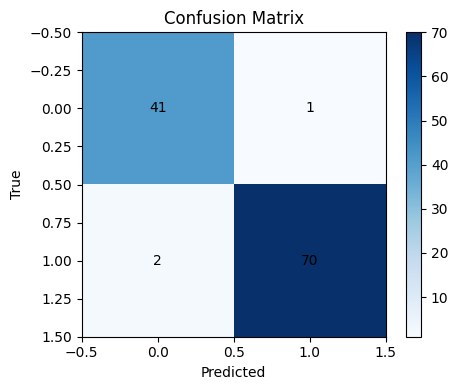

In [10]:
# 8) Predictions & metrics
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["class 0","class 1"]))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.colorbar(); plt.tight_layout(); plt.show()

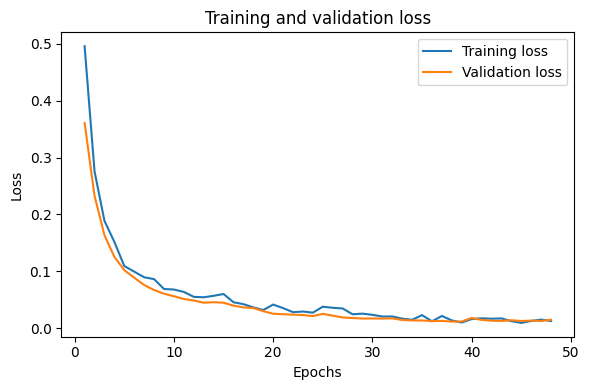

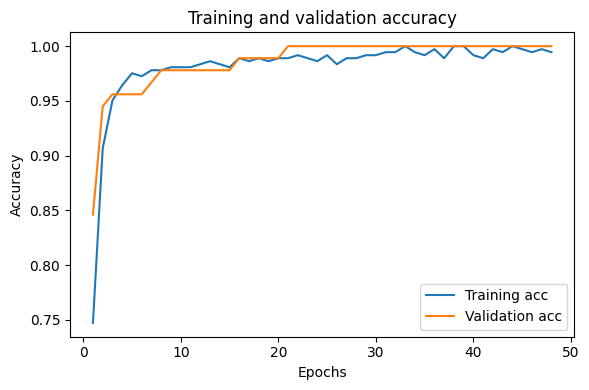

In [11]:
# 9) Learning curves
loss = history.history["loss"];       val_loss = history.history["val_loss"]
acc  = history.history["accuracy"];   val_acc  = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, acc, label="Training acc")
plt.plot(epochs, val_acc, label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.tight_layout(); plt.show()